In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def pdf_fig(figure, filename):
    figure = figure.get_figure()
    figure.savefig("../../thesis/img/big-study/" + filename + ".pdf", bbox_inches = "tight")

In [3]:
# seaborn styling
sns.set_style("darkgrid")
sns.set_palette(sns.husl_palette(h=.5, s=1))
sns.set_context("talk")

def label_bars_ints(ax):
    for p in ax.patches:
        ax.annotate("%.0i" % np.nan_to_num(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
            textcoords='offset points')

def label_bars_floats(ax):
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
            textcoords='offset points')

def process_fig(ax, name, technique, int_annotation, hue_title):
    if (int_annotation):
        label_bars_ints(ax)
    else:
        label_bars_floats(ax)
    if (hue_title != ''):
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title=hue_title)
    pdf_fig(ax, name + '-' + technique)
    plt.show()
    ax.clear()

In [4]:
techniques = ['PBE', 'TS', 'SKWS', 'RLR']
bool_order = [True, False]

In [5]:
pbe = pd.read_csv('pbe.csv')
pbe['Technique'] = 'PBE'
ir = pd.read_csv('ir.csv')
ir['Technique'] = 'TS'
kw = pd.read_csv('keyword.csv')
kw['Technique'] = 'SKWS'
rn = pd.read_csv('random.csv')
rn['Technique'] = 'RLR'
frames = [pbe, ir, kw, rn]

result = pd.concat(frames)
result.rename(columns={'Unnamed: 0':'v',
                       'TestOutput':'Test Output',
                       'DesiredTestOutput':'Desired Test Output',
                       'ExampleCount':'Example Count',
                       'LearningDuration':'Learning Duration',
                       'ApplicationDuration':'Application Duration'}, inplace=True)

def calc_overlapping_lines(row):
    lines_desired = str(row['Desired Test Output']).splitlines()
    lines_output = str(row['Test Output']).splitlines()
    overlap = list((Counter(lines_output) & Counter(lines_desired)).elements())
    row['True Positives Count'] = len(overlap)
    row['False Positives Count'] = len(lines_output) - len(overlap)
    row['False Negatives Count'] = len(lines_desired) - len(overlap)
    row['Output Lines Count'] = len(lines_output)
    row['Desired Lines Count'] = len(lines_desired)
    row['All Desired Lines Extracted'] = row['False Negatives Count'] == 0
    return row

result = result.apply(calc_overlapping_lines, axis=1)

result.head()

,v,Example Count,LearnedProgram,TestInputPath,Test Output,Desired Test Output,Accuracy,IoU,Successful,Learning Duration,...,SearchKeywords,AllKeywords,Categories,Technique,True Positives Count,False Positives Count,False Negatives Count,Output Lines Count,Desired Lines Count,All Desired Lines Extracted
0,1,1,"let s = v in let s = StartToPosRegion(s, Regex...",../tool/samples/C#/NancyFx@Nancy/failed/375800...,no extraction found for this input,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.027049,0.0,False,00.27.748,...,"error, ,","error, ,",0,PBE,0,1,29,1,29,False
1,2,2,NaN,../tool/samples/C#/NancyFx@Nancy/failed/377324...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.09.160,...,"error, , , FAIL, Failure, Error","error, , , FAIL, Failure, Error",0-1,PBE,0,1,15,1,15,False
2,3,3,NaN,../tool/samples/C#/NancyFx@Nancy/failed/382556...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.14.946,...,"error, , , FAIL, Failure, Error, FAIL, Failure...","error, , , FAIL, Failure, Error, FAIL, Failure...",0-1-1,PBE,0,1,15,1,15,False
3,4,4,NaN,../tool/samples/C#/NancyFx@Nancy/failed/386536...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00.21.461,...,"error, , , FAIL, Failure, Error, FAIL, Failure...","error, , , FAIL, Failure, Error, FAIL, Failure...",0-1-1-1,PBE,0,1,15,1,15,False
4,5,5,NaN,../tool/samples/C#/NancyFx@Nancy/failed/405164...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00.27.039,...,"error, , , FAIL, Failure, Error, FAIL, Failure...","error, , , FAIL, Failure, Error, FAIL, Failure...",0-1-1-1-1,PBE,0,1,15,1,15,False


In [6]:
def rtf(result,technique):
    return result[result['Technique'] == technique]

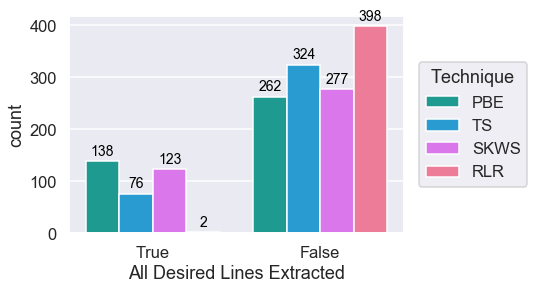

In [7]:
# all techniques - extracted desired log part
ax = sns.countplot(x='All Desired Lines Extracted', hue='Technique', data=result, order=bool_order)
process_fig(ax, 'success', 'all', True, 'Technique')

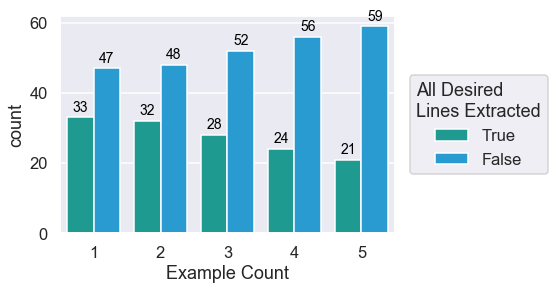

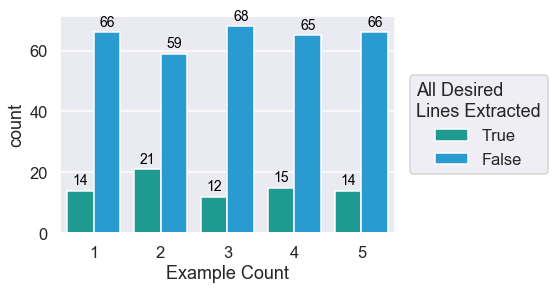

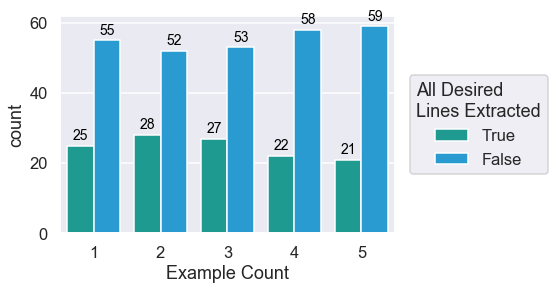

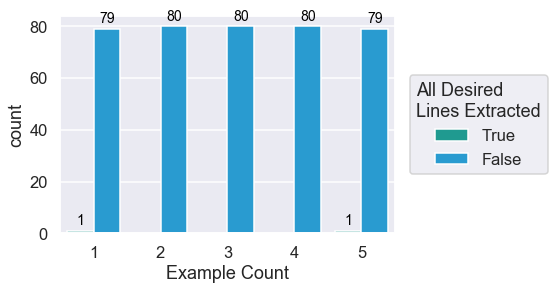

In [8]:
# separate technique success rate against number of examples
#ax = sns.catplot(x='ExampleCount', col='Technique', hue = 'AllDesiredExtracted',
#                 data=result, kind='count')
def plot_examples_success_technique(technique):
    ax = sns.countplot(x='Example Count', hue='All Desired Lines Extracted',
                  data=rtf(result,technique), hue_order=bool_order)
    process_fig(ax, 'success-examples', technique, True, 'All Desired\nLines Extracted')

for technique in techniques:
    plot_examples_success_technique(technique)

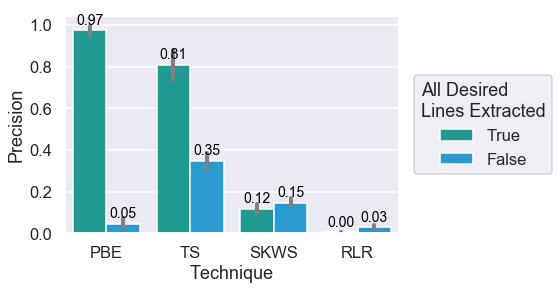

In [9]:
# precision of extraction: how much of the extracted text is actually necessary
result['Precision'] = result['True Positives Count'] / result['Output Lines Count']

ax = sns.barplot(x='Technique', y='Precision', hue='All Desired Lines Extracted', data=result, hue_order=bool_order, errcolor='grey')
process_fig(ax, 'precision', 'all', False, 'All Desired\nLines Extracted')

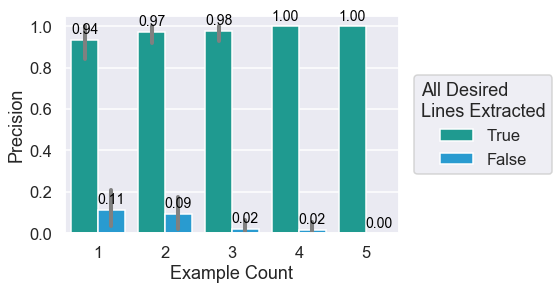

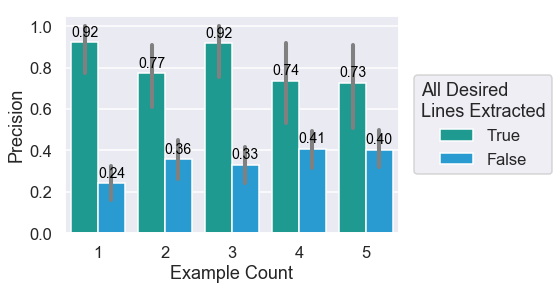

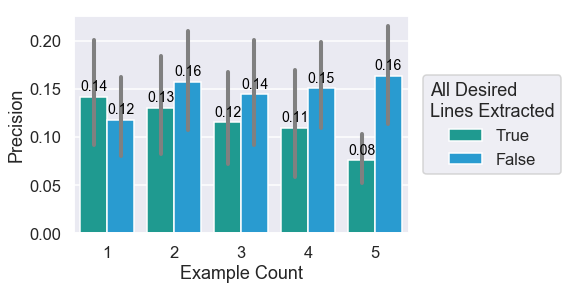

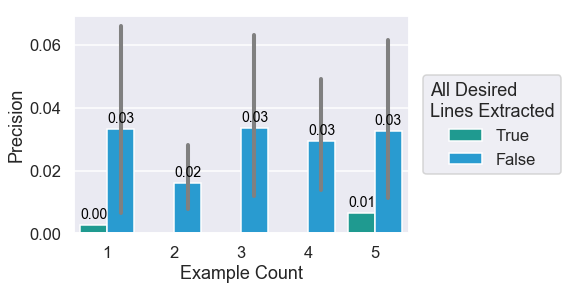

In [10]:
# precision one technique against example count
def precision_examples(technique):
    ax = sns.barplot(x='Example Count', y='Precision', hue='All Desired Lines Extracted', data=rtf(result, technique), hue_order=bool_order, errcolor='grey')
    process_fig(ax, 'precision', technique, False, 'All Desired\nLines Extracted')

for technique in techniques:
    precision_examples(technique)

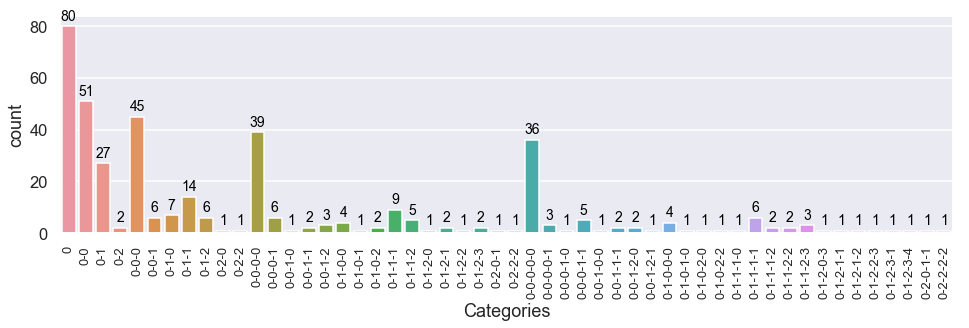

In [11]:
# category distribution
pbe_result = rtf(result, 'PBE')
plt.figure(figsize=(16,4))
order = list(set(pbe_result['Categories']))
order.sort()
order.sort(key = len)
ax = sns.countplot(x='Categories', data=pbe_result, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=13, horizontalalignment='center')
process_fig(ax, 'categories', 'dataset', True, '')

In [12]:
def category_count(categories):
    return len(set(categories.split('-')))

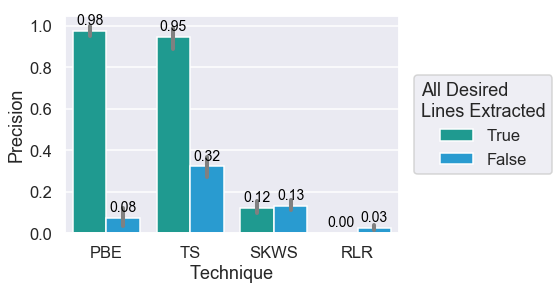

In [13]:
# single-category-precsion
result['Category Count'] = result.apply(lambda x : category_count(x['Categories']), axis=1)
result['Single Category'] = result['Category Count'] == 1
result_single_category = result[result['Single Category']]
ax = sns.barplot(x='Technique',
                 y='Precision',
                 hue='All Desired Lines Extracted',
                 data=result_single_category,
                 hue_order=bool_order,
                 errcolor='grey')
process_fig(ax, 'single-cateogry-precision', 'all', False, 'All Desired\nLines Extracted')

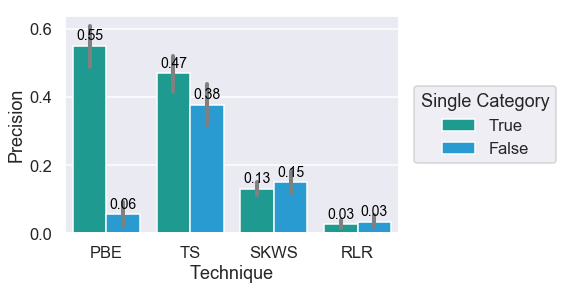

In [14]:
# single category vs. multiple
ax = sns.barplot(x='Technique', y='Precision', hue='Single Category', data=result, hue_order=bool_order, errcolor='grey')
process_fig(ax, 'precision-category-singularity', 'all', False, 'Single Category')

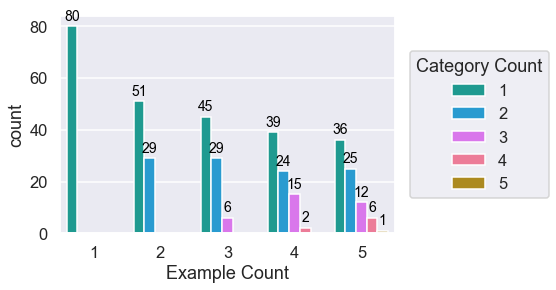

In [15]:
# category count
ax = sns.countplot(x='Example Count', hue='Category Count', data=rtf(result, 'PBE'))
process_fig(ax, 'categorycount-examplecount', 'dataset', True, 'Category Count')

In [16]:
# category count vs example count
# ax = sns.barplot(x='ExampleCount', y='CategoryCount', data=rtf(result, 'pbe'))
# process_fig(ax, 'categorycount-examplecount', 'dataset', False, '')

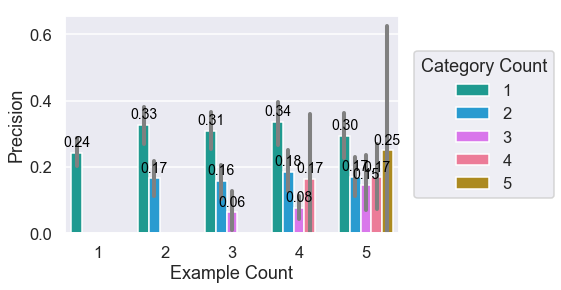

In [17]:
ax = sns.barplot(x='Example Count', y='Precision', hue='Category Count', data=result, errcolor='grey')
process_fig(ax, 'precision-categorycount-examplecount', 'all', False, 'Category Count')

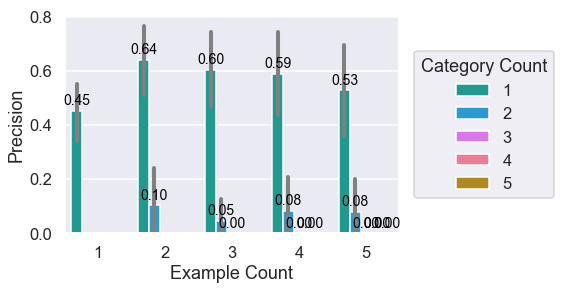

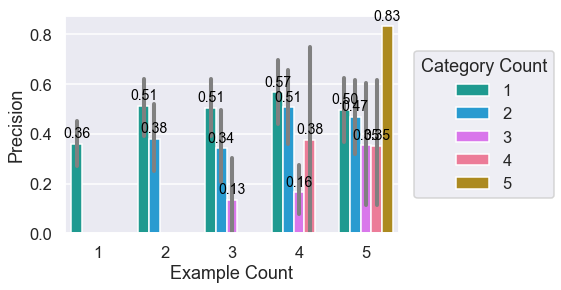

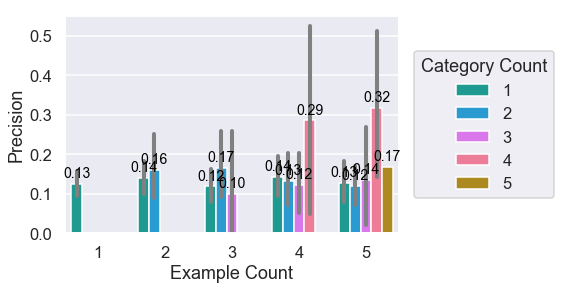

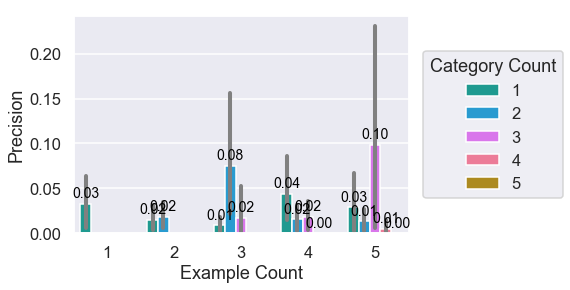

In [18]:
def example_count_category_count_precision(technique):
    ax = sns.barplot(x='Example Count', y='Precision', hue='Category Count', data=rtf(result, technique), errcolor='grey')
    process_fig(ax, 'precision-categorycount-examplecount', technique, False, 'Category Count')

for technique in techniques:
    example_count_category_count_precision(technique)

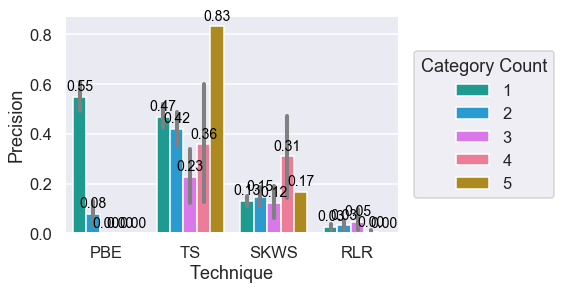

In [19]:
# example count category comparing techniques in one picture
ax = sns.barplot(x='Technique', y='Precision', hue='Category Count',
                 data=result, errcolor='grey')
process_fig(ax, 'categorycount-precision', 'all', False, 'Category Count')

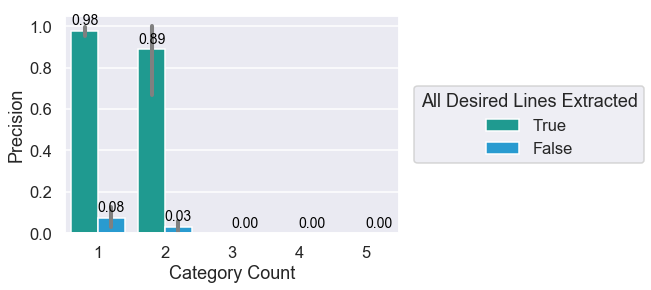

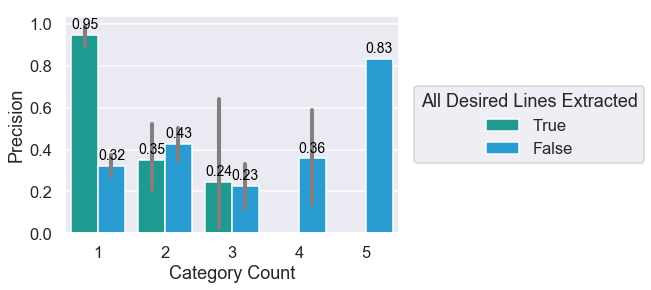

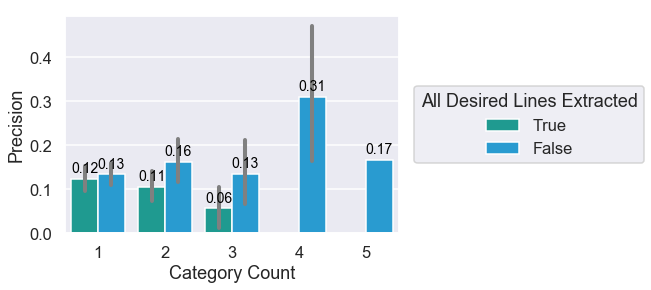

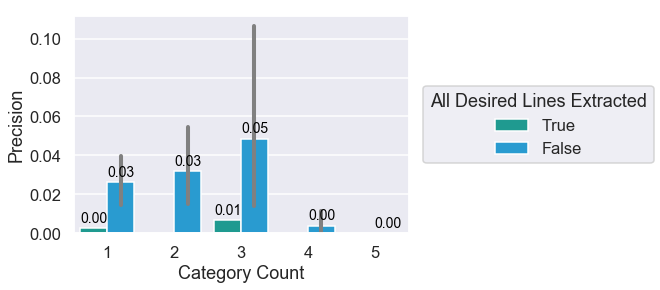

In [20]:
# success of extractions against category counts
def example_count_success(technique):
    ax = sns.barplot(x='Category Count', y='Precision', hue='All Desired Lines Extracted',
                  data=rtf(result, technique), hue_order=bool_order, errcolor='grey')
    process_fig(ax, 'categorycount-success', technique, False, 'All Desired Lines Extracted')
    
for technique in techniques:
    example_count_success(technique)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



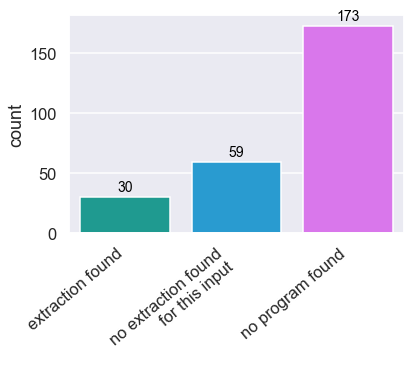

In [21]:
# pbe: if the extraction failed, why did it fail? (when was no program learned/regex did not match?)
failed = result[(result['All Desired Lines Extracted'] == False) & (result.Technique == 'PBE')]
# failed_pbe = failed
failed.loc[failed['Test Output'].isin(['no program found', 'no extraction found for this input']), 'to'] = failed['Test Output']
failed.loc[~failed['Test Output'].isin(['no program found', 'no extraction found for this input']), 'to'] = 'extraction found'
failed.loc[failed['to'] == 'no extraction found for this input', 'to'] = 'no extraction found\nfor this input'
pbe_fail_order = ['extraction found', 'no extraction found\nfor this input', 'no program found']

ax = sns.countplot(x="to", data=failed, order=pbe_fail_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('')
process_fig(ax, 'failure-reason', 'PBE', True, '')

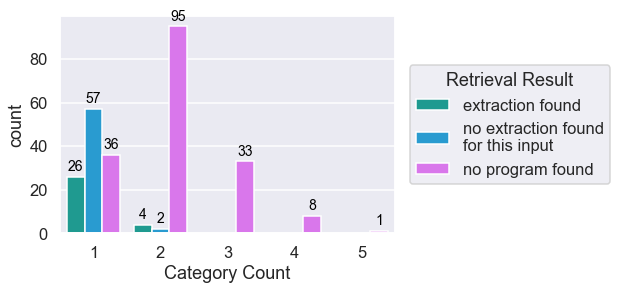

In [22]:
# pbe failure reason against category count
ax = sns.countplot(x='Category Count', hue='to', data=failed, hue_order=pbe_fail_order)
process_fig(ax, 'failure-reason-categorycount', 'PBE', True, 'Retrieval Result')

In [23]:
timed_result = result
timed_result['Learning Duration'] = pd.to_datetime(result['Learning Duration'],format='%M.%S.%f') - pd.Timestamp('1900-01-01 00:00:00.000')
timed_result['Application Duration'] = pd.to_datetime(result['Application Duration'],format='%M.%S.%f') - pd.Timestamp('1900-01-01 00:00:00.000')

In [24]:
#timed_result.head()

,v,Example Count,LearnedProgram,TestInputPath,Test Output,Desired Test Output,Accuracy,IoU,Successful,Learning Duration,...,Technique,True Positives Count,False Positives Count,False Negatives Count,Output Lines Count,Desired Lines Count,All Desired Lines Extracted,Precision,Category Count,Single Category
0,1,1,"let s = v in let s = StartToPosRegion(s, Regex...",../tool/samples/C#/NancyFx@Nancy/failed/375800...,no extraction found for this input,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.027049,0.0,False,00:00:27.748000,...,PBE,0,1,29,1,29,False,0.0,1,True
1,2,2,NaN,../tool/samples/C#/NancyFx@Nancy/failed/377324...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00:00:09.160000,...,PBE,0,1,15,1,15,False,0.0,2,False
2,3,3,NaN,../tool/samples/C#/NancyFx@Nancy/failed/382556...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00:00:14.946000,...,PBE,0,1,15,1,15,False,0.0,2,False
3,4,4,NaN,../tool/samples/C#/NancyFx@Nancy/failed/386536...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012739,0.0,False,00:00:21.461000,...,PBE,0,1,15,1,15,False,0.0,2,False
4,5,5,NaN,../tool/samples/C#/NancyFx@Nancy/failed/405164...,no program found,Nancy.Testing.Tests.BrowserFixture.Should_retu...,0.012882,0.0,False,00:00:27.039000,...,PBE,0,1,15,1,15,False,0.0,2,False


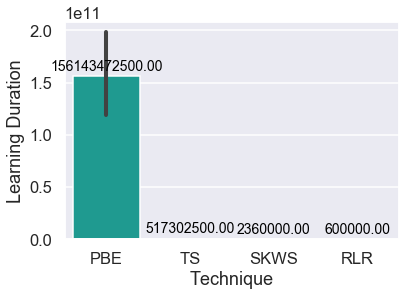

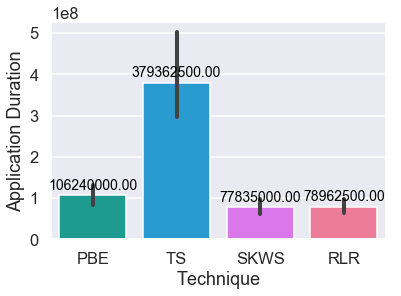

ValueError: Could not convert object to NumPy timedelta

In [25]:
# learning & application duration for all,
ax = sns.barplot(x='Technique', y='Learning Duration', data=timed_result)
process_fig(ax, 'learning-duration', 'all', False, '')

ax = sns.barplot(x='Technique', y='Application Duration', data=timed_result)
process_fig(ax, 'application-duration', 'all', False, '')

# learning duration for pbe,
ax = sns.barplot(x='Example Count', y='Learning Duration',
                 hue='Category Count', data=rtf(timed_result, 'PBE'))
process_fig(ax, 'learning-duration-examplecount', 'pbe', False, 'Category Count')

# learning duration for pbe per type?